# Spindles and the Hirsch conjecture II

In the second part of the tutorial, we will be analyzing the lowest-dimensional counterexample to the (bounded)
Hirsch conjecture known to date. It is a spindle with 40 facets in dimension 20 that is
constructed from a 5-dimensional "base" spindle found by
[Matschke, Santos, and Weibel](https://arxiv.org/abs/1202.4701). Following the terminology
of part I of this tutorial, our goal is to find *good 2-faces*.

## Good faces in dimension 5

To begin, let us enumerate the good 2-faces of the 5-dimensional spindle.

In [1]:
using Spindles
A, b, = readineq("../../../examples/s-25-5.txt", BigInt)
s = Polytope(A, b)
apx = apices(s)

2-element Vector{Int64}:
  1
 64

> **Note**
>
> We created `s` from rational data with numerators and denominators of type `BigInt`
> (this is the second argument passed to `readineq`). Choosing `Int` here (as in part I
> of this tutorial) would have produced an integer overflow error. See also the section on
> [arbitrary-precision arithmetic](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/#Arbitrary-Precision-Arithmetic)
> in the Julia language documentation.

The following code finds all good 2-faces of `s`.

In [2]:
goodfaces = []
for f in sort(facesofdim(s, 2))
    fstate = isgood2face(s, f, apx...)
    if fstate.good
        push!(goodfaces, fstate)
    end
end
length(goodfaces)

32

Next, let's plot the graph of each of those 32 good 2-faces:

In [3]:
using Plots

dist_labels = map(1:nvertices(s)) do v
    "$v\n" * join(dist.(s, apx, v), " | ")
end

plot_arr = []
for fstate in goodfaces
    push!(plot_arr,
        plot2face(s, fstate.facets;
            vertexlabels=dist_labels, usecoordinates=false, directed_edges=fstate.edges
        )
    )
end

ncols = 4
nrows = ceil(Int, length(plot_arr) / ncols)
plot(plot_arr..., layout=(nrows, ncols), size=(1000, nrows*300), plot_title="Good 2-faces")
plot_arr = nothing # hide

## Good faces in dimension 20

### Patterns in the inequality description
As a warm-up, let's take a look at the inequality description of the 20-dimensional spindle.
A minimal description is provided in the file `s-25.txt`:

In [4]:
print(read("../../../examples/s-25.txt", String))

# 20-dimensional spindle with 40 facets and length 21
# due to Matschke, Santos, and Weibel (see Table 1 in https://arxiv.org/abs/1202.4701)
3 1 -1 0 0 -21 7 0 0 0 0 0 0 0 0 0 0 -1 -1 0 0 0
7 1 -1 0 0 -16 15 0 0 0 0 0 0 0 0 0 0 0 -1 -1 0 0
2 1 -1 0 0 0 32 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 0
8 1 -1 0 0 16 15 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1
4 1 -1 0 0 21 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
6 1 -1 0 0 20 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1
1 1 -1 0 0 0 -32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
5 1 -1 0 0 -20 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
9 1 -1 -3/50 1/25 0 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10 1 -1 3/50 1/25 0 -30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12 1 -1 3/1000 -7/1000 0 -159/5 0 0 0 0 0 0 0 0 0 -1 0 0 0 0 0
11 1 -1 -3/1000 -7/1000 0 159/5 -10000000 -10000000 -10000000 -10000000000 -100000000000 -100000000000 -100000000000 -100000000000 -1 0 0 0 0 0 0
11 1 -1 -3/1000 -7/1000 0 159/5 10000000 0 0 0 0 0 0 0 -1 0 0 0 0 0 0
11 1 -1 -3/1000 -7/1000 0 159/5 -10000000 10000000 0 0 0 0 0 0 -1 0 0 0 0 0 0
11 1 -1 -3/1

You may notice that the coefficients in the first couple of columns are very similar to
those of `A`, the coefficient matrix of the 5-dimensional "base" spindle `s`. This
similarity is no coincidence: the matrix encoded in the file above is derived from `A`
in a highly structured way.
Each row has a "counterpart" in `A`. For convenience, each row above is already
labeled by the index of its "counterpart". For example, the labels of the first three rows
(the numbers in the first column) are

In [5]:
[3, 7, 2]

3-element Vector{Int64}:
 3
 7
 2

and the corresponding rows of `A` are

In [6]:
A[[3, 7, 2],:]

3×5 Matrix{Rational{BigInt}}:
 1  0  0  21   -7
 1  0  0  16  -15
 1  0  0   0  -32

If you inspect those row labels closely, you may notice a pattern. Two labels appear multiple times,
namely  `11` and `25`. The corresponding rows of `A` have been "replicated" a number of times.
Each time, a new nonzero entry is added to the right whose order of magnitude is much larger than
that of all other coefficients. At the polyhedral level, this "replication" of rows is reflected by
an operation called *wedging*, which plays a crucial role in Santos' construction of a Hirsch
counterexample from spindles like `s`.

The structure that we just observed will be extremely useful in "guessing" good 2-faces of the
20-dimensional spindle encoded in the file above.

### Building the spindle
Before we examine its faces, let us first
read the file and construct a `Spindle` object from it.

In [7]:
A20, b20, labels = readineq("../../../examples/s-25.txt", BigInt)
s20 = Polytope(A20, b20)

Polytope{Rational{BigInt}}

To speed up computations, we tell the function `apices` that
the system of linear inequalities specified by `A20` and `b20` is known to be minimal,
by using the keyword argument `checkredund` (see also the API documentation on `apices`):

In [8]:
apx20 = apices(s20; checkredund=false)
collect(vertices(s20))[apx20]

2-element Vector{Vector{Rational{BigInt}}}:
 [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Note that `s20` is simple:

In [9]:
using Graphs: degree
all(degree(graph(s20)) .== dim(s20))

true

Its most important property, however, is the length of a shortest path between the apices:

In [10]:
dist(s20, apx20...)

21

The Hirsch conjecture would imply that there must be a strictly shorter path, namely of length 20.
Therefore, `s20` is a counterexample to the Hirsch conjecture.

You may have noticed that computations in dimension 20 take longer than they did in dimension 5.
Calling `graph` or `dist` for the first time on `s20` (or any `Spindles` function that needs
the graph, in fact) triggers the computation of the entire graph of `s20`. Luckily, we don't
have to enumerate all 2-faces of `s20` to identify good ones.
Instead, we may take advantage of the structure in its coefficient matrix to "guess" good 2-faces.

### "Guessing" good 2-faces

For example, here is one of the good 2-faces of `s` again:

In [11]:
face = [2,8,9]
isgood2face(s, face, apx...).good

true

The corresponding facets of `s20` are

In [12]:
face20 = [i for (i,label) in enumerate(labels) if parse(Int, label) in face]

3-element Vector{Int64}:
 3
 4
 9

However, three facets do not make a 2-face in dimension 20 yet. We need another 15 facet-defining
inequalities from the description of `s20` (recall that `s20` is simple). With some geometric intuition of what the wedging
operation does, we propose the following rule of thumb: To get up to 18 facets, pick facets from
those two blocks of "replications" labeled `11` and `25`. Specifically, from each block, pick all
facets but one. Let us calculate the number of facets in each block:

In [13]:
sum(labels .== "11"), sum(labels .== "25")

(9, 8)

So, in total, our proposed rule of thumb would indeed give us the desired number of $9+8-2=15$ facets.
Let us "validate" this rule on `face`.

In [14]:
blocks = [findall(labels .== ref) for ref in ["11", "25"]]  # all row indices in either of the two blocks
face20 = [face20; blocks[1][2:end]; blocks[2][2:end]]
join(unique(labels[face20]), " ")

"2 8 9 11 25"

This is the face we would expect to be a good 2-face. Let's check whether it really is:

In [15]:
isgood2face(s20, face20, apx20...).good

true

Great! By omitting the first facet from each block, we immediately found a good 2-face of `s20`.
Let us plot this face and the original one in dimension 5 side by side.

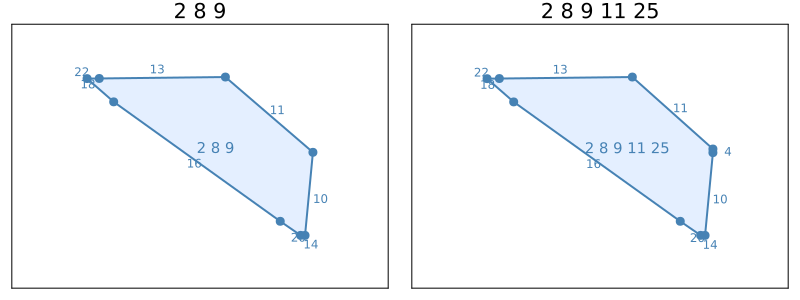

In [16]:
plot(
    plot2face(s, face; vertexlabels=nothing),
    plot2face(s20, face20; vertexlabels=nothing, ineqlabels=labels),
    layout=grid(1,2), size=(800,300)
)

Not only do their projections look very similar, they are also combinatorially almost identical.
To see this, let us make plots of their graphs. For `s20`, we would like the same kind of vertex labels
that we generated for the smaller spindle above:

In [17]:
dist_labels20 = nothing # hide

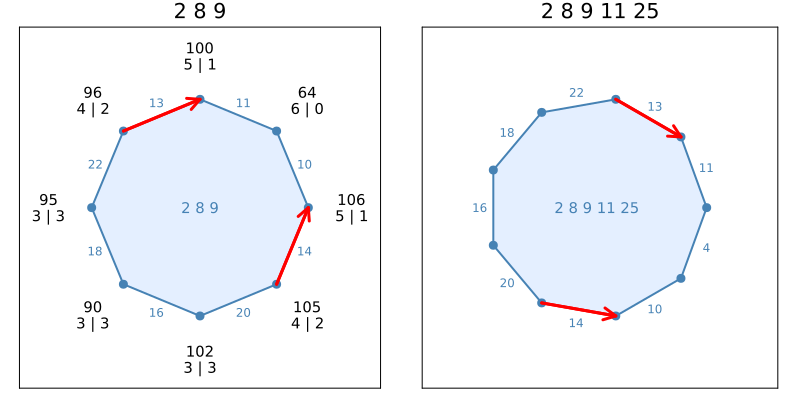

In [18]:
edges = isgood2face(s, face, apx...).edges
edges20 = isgood2face(s20, face20, apx20...).edges

plot(
    plot2face(s, face; directed_edges=edges, vertexlabels=dist_labels, usecoordinates=false),
    plot2face(s20, face20; directed_edges=edges20, vertexlabels=dist_labels20, ineqlabels=labels, usecoordinates=false),
    layout=grid(1,2), size=(800,400)
)

The figure on the right is the graph of the 2-face in dimension 20, with facets labeled by
which facets of the 5-dimensional spindle `s` they correspond to. Combinatorially,
the only change is an additional edge (the one defined by `4`). Most importantly, however,
the property of being good is preserved, since the two vertex sets $V_1$ and $V_2$ are still sufficiently
close to the apices. Here, "sufficiently close" again means that there are paths from any pair of vertices in
$V_1$ and $V_2$ to the apices `apx20[1]` and `apx20[2]`, respectively, of total length $20-2=18$.

### ...

Next, let us take this one step further and find such a good 2-face in dimension 20 for each of
the good 2-faces of `s`.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*